In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import random
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

In [2]:
final_df = pd.read_csv("final_df.csv", index_col = 0)

In [95]:
selected_columns = ['name','hour_of_year','laeq','Year', 'Month', 'Day', 'Hour',
       'LC_HUMIDITY', 'LC_DWPTEMP', 'LC_RAD', 'LC_RAININ', 'LC_WINDDIR',
       'LC_WINDSPEED', 'LC_TEMP', 'Human voice - Shouting',
       'Human voice - Singing', 'Music non-amplified',
       'Nature elements - Wind', 'Transport road - Passenger car',
       'Transport road - Siren', 'latitude', 'longitude', 'day_name']
df_ml = final_df[selected_columns]

In [96]:
grouped = df_ml.groupby('name')

# Creating a dictionary to store the resulting DataFrames
dfs = []

# Splitting the DataFrame based on groups
for nm,df in grouped:
    dfs.append(df)
full_dfs=[]
for df in dfs:
    if(len(df)>8740):
        full_dfs.append(df)

In [97]:
def fill_df(df1):
    unchanged_columns = ['name','latitude','longitude','day_name','Year','Month','Day']
    event_columns = ['Human voice - Shouting','Human voice - Singing', 'Music non-amplified',
           'Nature elements - Wind', 'Transport road - Passenger car',
           'Transport road - Siren']
    numeric_columns = ['laeq','LC_HUMIDITY', 'LC_DWPTEMP', 'LC_RAD', 'LC_RAININ', 'LC_WINDDIR',
           'LC_WINDSPEED', 'LC_TEMP']

    imputed_values = df1['actual'].fillna("True")
    df1['actual'] = imputed_values

    df1["Hour"].fillna(df['Hour'].ffill(), inplace=True)
    df1["Hour"].fillna(df['Hour'].ffill() + 1, inplace=True)
    for column in unchanged_columns:
        df1[column].fillna(method='ffill', inplace=True)
    for column in event_columns:
        df1[column].fillna(0,inplace = True)
    for column in numeric_columns:
        df1[column].fillna(df[column].ffill() + df[column].ffill()/(random.randint(40, 80)), inplace=True)
    return df1

In [98]:
def fill_df_predictions(df1):
    unchanged_columns = ['name','latitude','longitude']
    event_columns = ['Human voice - Shouting','Human voice - Singing', 'Music non-amplified',
           'Nature elements - Wind', 'Transport road - Passenger car']
    for column in unchanged_columns:
        df1[column].fillna(method='ffill', inplace=True)
    return df1

In [99]:
updated_full_dfs = []
for df in full_dfs:
    set1 = set(df["hour_of_year"])
    set2 = set(list(range(8759)))
    difference = list(set2-set1)
    print(difference)
    for d in difference:
        new_row = pd.DataFrame({'hour_of_year': [d],'actual':False})
        # Concatenate the new row to the existing DataFrame
        df = pd.concat([df, new_row], ignore_index=True)
    df = df.sort_values("hour_of_year").reset_index().drop(columns = ["index"])
    updated_full_dfs.append(df)
for i in range(len(updated_full_dfs)):
    df = updated_full_dfs[i]
    df = fill_df(df)
    updated_full_dfs[i] = df

[6585, 2042]
[608, 609, 610, 611, 612, 2042, 601, 602, 603, 604, 605, 606, 607]
[2042]


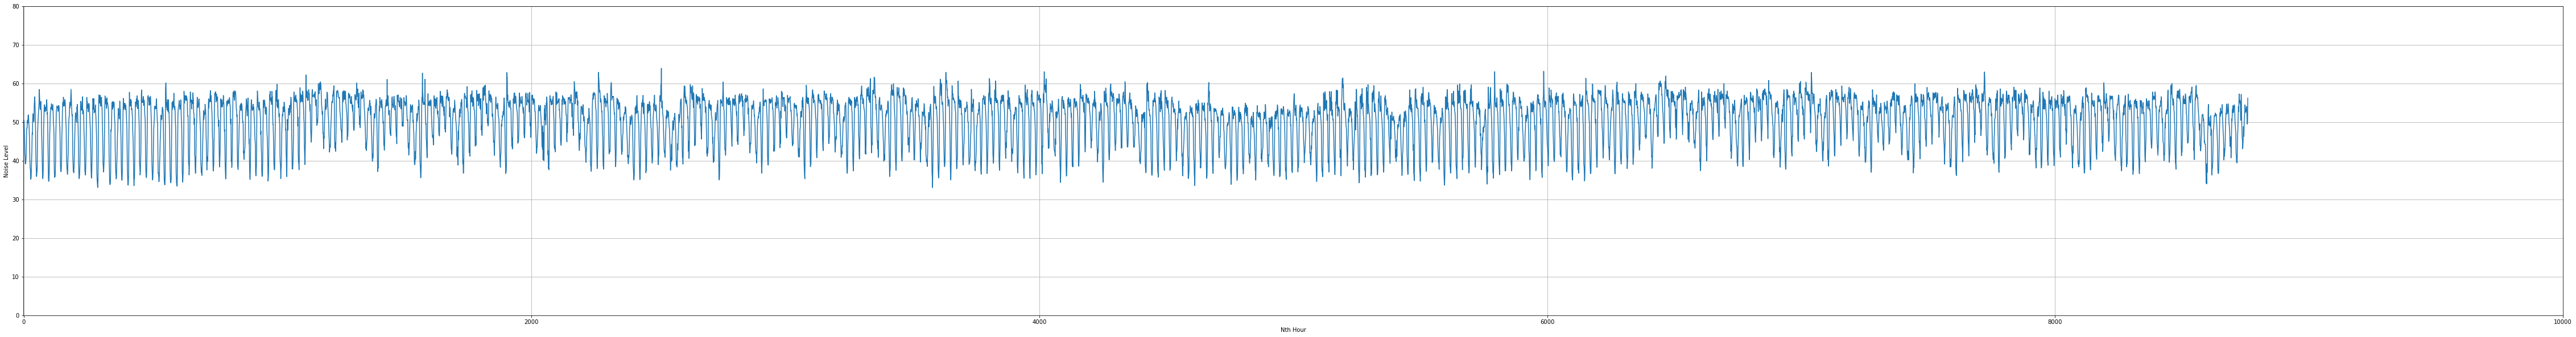

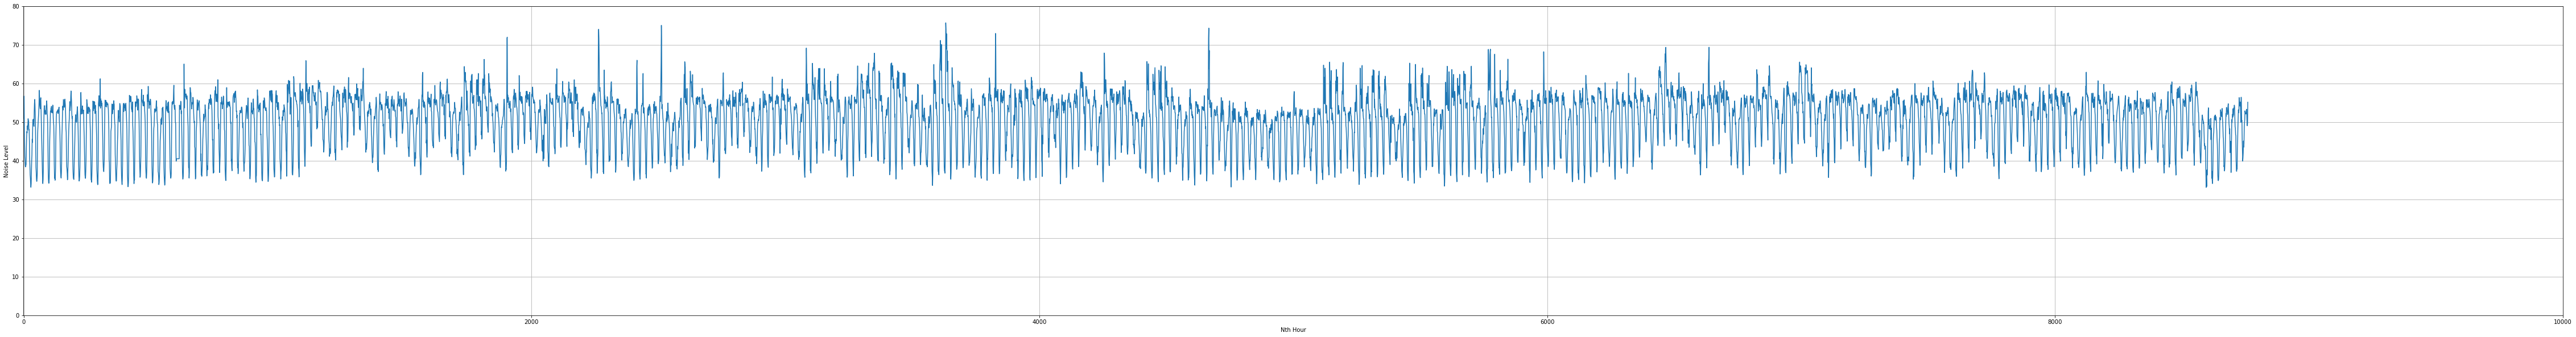

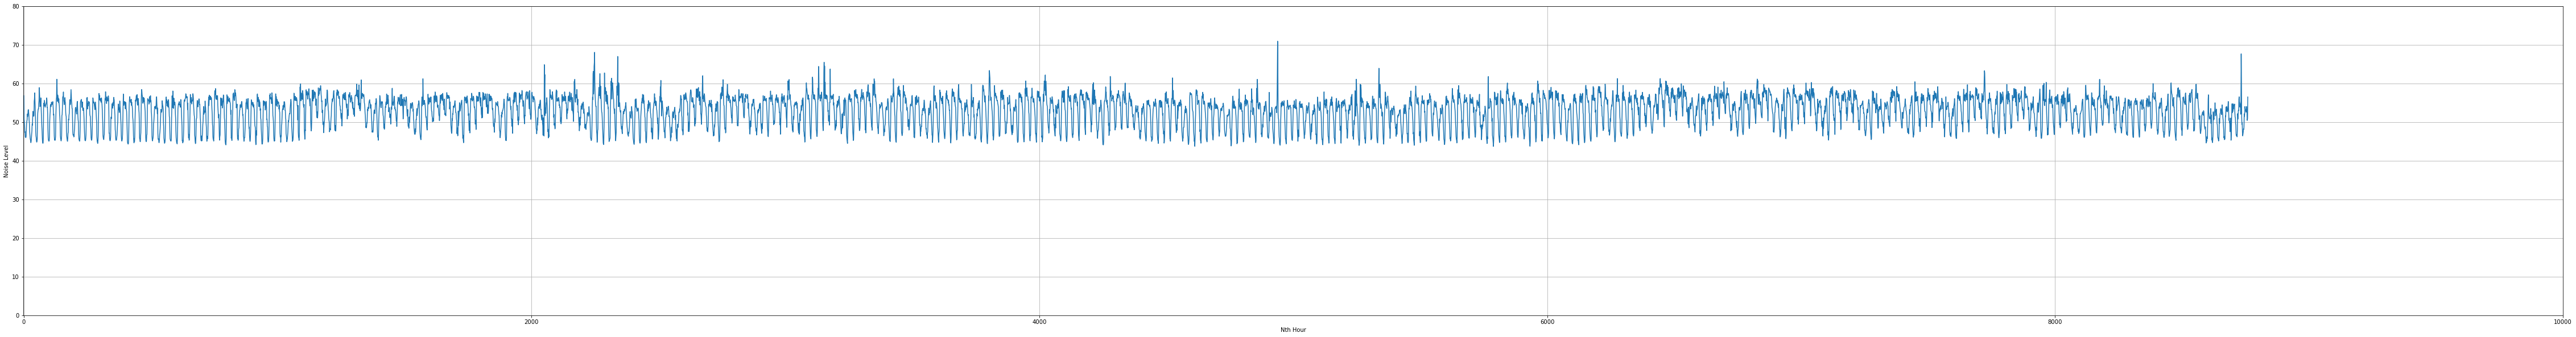

In [100]:
def plotNoise(df):
    plt.figure(figsize=(80, 10))
    plt.plot(df['hour_of_year'], df['laeq'])
    plt.grid(True)
    plt.xlim(-2,10000)
    plt.ylim(0,80)
    plt.xlabel('Nth Hour')
    plt.ylabel('Noise Level')
    plt.show()
for df in updated_full_dfs:
    plotNoise(df)

In [101]:
def predictNextHours(data):
    
    data.set_index('hour_of_year', inplace=True)

    data = data.drop(columns=["name","day_name","actual"])

    train_data = data["laeq"].iloc[:len(data)]

    model = SARIMAX(train_data, order=(12,2,1))
    model_fit = model.fit()

    predictions = model_fit.predict(start=len(train_data), end=len(train_data) + 720 - 1)

    for prediction in predictions:
        new_row = pd.DataFrame({'laeq': [prediction],'actual':True})
        data = pd.concat([data, new_row], ignore_index=True)
    data["hour_of_year"] = data.index
    return(data)

In [102]:
def predictNextHoursNaive(data):
    
    last_value = data["laeq"].iloc[-1]
    diff = 100
    for i in range(len(data)):
        value = data["laeq"].iloc[i]
        if(last_value - value < diff):
            diff = last_value - value
            index = i
    predictions = data["laeq"].iloc[index:index+500].values
    for prediction in predictions:
        new_row = pd.DataFrame({'laeq': [prediction],'actual':False})
        data = pd.concat([data, new_row], ignore_index=True)
    data["hour_of_year"] = data.index
    return(data)

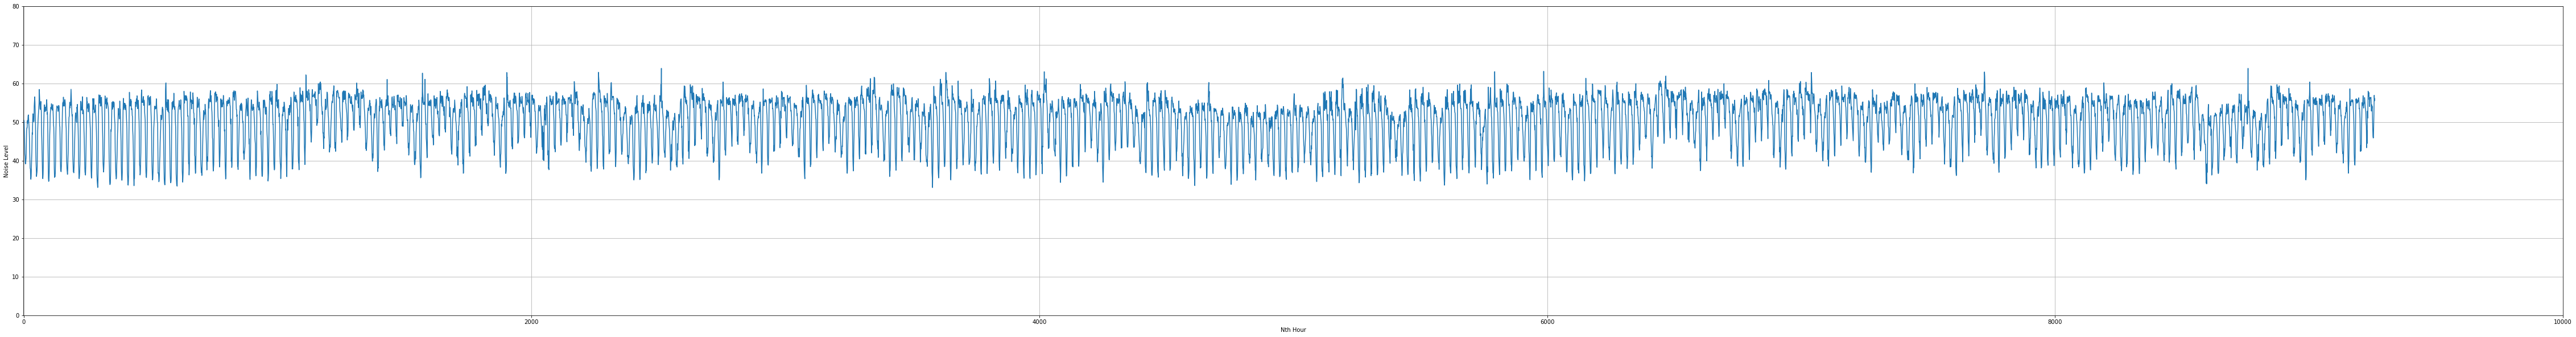

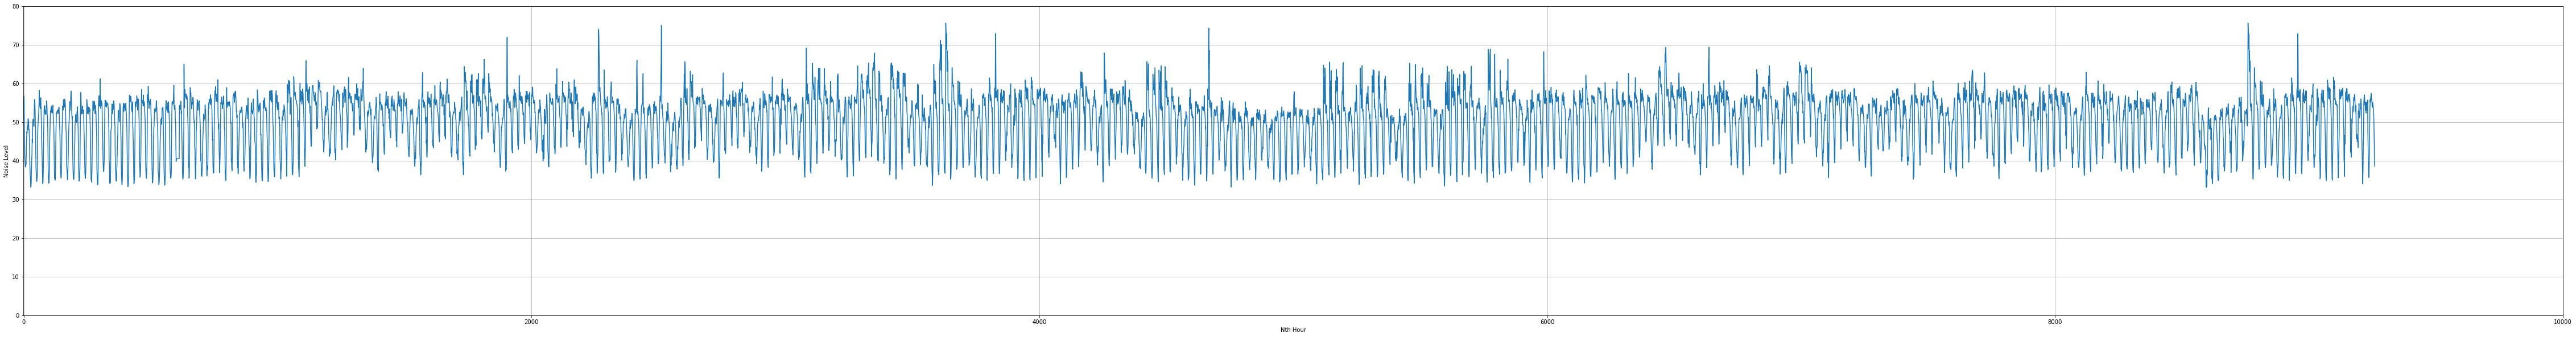

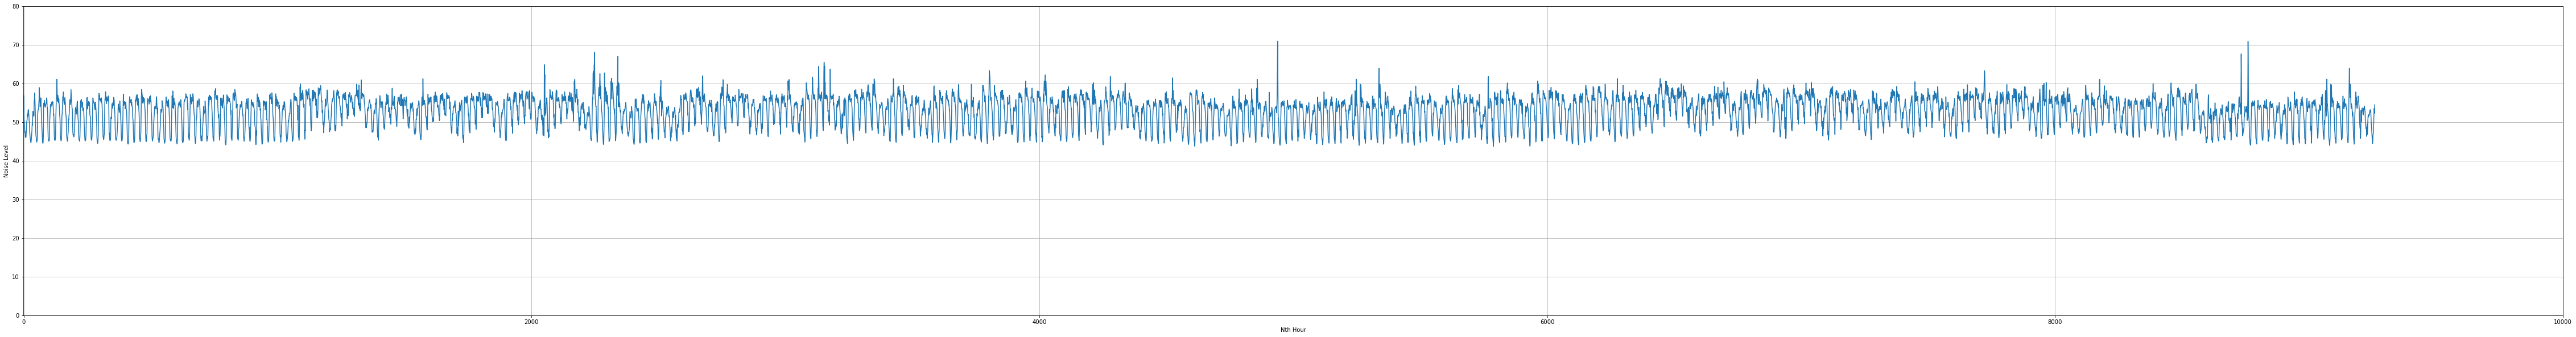

In [103]:
for df in updated_full_dfs:
    df = predictNextHoursNaive(df)
    plotNoise(df)
    df = fill_df_predictions(df)

In [104]:
for i in range(len(updated_full_dfs)):
    df = updated_full_dfs[i]
    df = predictNextHoursNaive(df)
    df = fill_df_predictions(df)
    updated_full_dfs[i] = df

In [105]:
noise_prediction_df = pd.DataFrame()
for df in updated_full_dfs:
    last_500_rows = df[-500:]
    noise_prediction_df = pd.concat([noise_prediction_df, last_500_rows], ignore_index=True)

In [106]:
noise_prediction_df = noise_prediction_df[["name","hour_of_year","laeq","latitude","longitude","actual"]]
noise_prediction_df.to_csv("noise_predictions.csv")

In [120]:
noise_prediction_df = pd.read_csv("noise_predictions.csv",index_col = 0)

In [121]:
final_df['hour_of_year'] =  final_df['hour_of_year'] + 8760
final_df = final_df[["name","hour_of_year","Year","Month","Day","Hour"]]
final_df["Year"] = final_df["Year"] + 1

In [123]:
noise_prediction_df= pd.merge(noise_prediction_df,final_df,on=['name', 'hour_of_year'],how = "left")

In [124]:
noise_prediction_df.to_csv("noise_predictions.csv")

,name,hour_of_year,laeq,latitude,longitude,actual,Year,Month,Day,Hour
0,Calvariekapel KU Leuven,8760,63.958750,50.874615,4.699986,False,2023,1,1,0
1,Calvariekapel KU Leuven,8761,55.445417,50.874615,4.699986,False,2023,1,1,1
2,Calvariekapel KU Leuven,8762,53.702500,50.874615,4.699986,False,2023,1,1,2
3,Calvariekapel KU Leuven,8763,55.507083,50.874615,4.699986,False,2023,1,1,3
4,Calvariekapel KU Leuven,8764,54.522083,50.874615,4.699986,False,2023,1,1,4
...,...,...,...,...,...,...,...,...,...,...
1495,Taste,9255,49.662500,50.875891,4.700214,False,2023,1,21,15
1496,Taste,9256,52.479167,50.875891,4.700214,False,2023,1,21,16
1497,Taste,9257,53.598750,50.875891,4.700214,False,2023,1,21,17
1498,Taste,9258,52.288750,50.875891,4.700214,False,2023,1,21,18
